
<!DOCTYPE html>
<html>
  <head>
    <meta charset="UTF-8">
    <title>Backtesting Trading Strategy: EMA & ADX Optimization</title>
    <style>
      body {
        font-family: Arial, sans-serif;
        background-color: #f0f0f0;
        text-align: center;
        padding: 20px;
      }
      h1 {
        color: #2c3e50;
        font-size: 2.5em;
        margin-bottom: 0.1em;
      }
      h2 {
        color: #34495e;
        font-size: 2em;
        margin-top: 0;
      }
      p {
        color: #2c3e50;
        font-size: 1.2em;
        margin-top: 1em;
        max-width: 800px;
        margin-left: auto;
        margin-right: auto;
      }
    </style>
  </head>
  <body>
    <h1>Backtesting Trading Strategy: EMA &amp; ADX Optimization</h1>
    <h2>Machine Learning-Driven Parameter Tuning on Microsoft Stock</h2>
    <p>
      This project implements a backtesting trading strategy that uses a 5-minute EMA for momentum and mean reversion signals on a 1-hour chart,
      combined with the ADX indicator to gauge trend strength on a 5-minute chart. By leveraging the Optuna module for hyperparameter optimization,
      key parameters (such as EMA lengths, ADX window/threshold, stop loss, and target values) were tuned over a 3-month span. The backtest
      resulted in a total risk–reward ratio (RRR) of 41 for all trades, demonstrating a highly favorable risk profile.
    </p>
  </body>
</html>


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import numpy as np
import requests
import ta
import optuna

In [3]:
TICKER = 'MSFT'
START_DATE = "2025-01-20"    
END_DATE = "2025-03-15"      
INTERVAL_5M = "5m" 

In [4]:
df= yf.download(tickers = TICKER, start = START_DATE , end = END_DATE,interval = INTERVAL_5M)
df.dropna(inplace=True)  
df.sort_index(inplace=True) 
df.index=df.index.tz_convert('US/Eastern')
df
df_1h = yf.download(tickers = TICKER, start = START_DATE , end = END_DATE,interval = '1h')
df_1h.dropna(inplace=True)  
df_1h.sort_index(inplace=True) 
df_1h.index=df_1h.index.tz_convert('US/Eastern')
df_1h

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Datetime,,,,,
2025-01-21 09:30:00-05:00,428.470001,430.790009,425.595001,430.040009,4607395
2025-01-21 10:30:00-05:00,428.010010,428.939911,427.010010,428.420013,1321631
2025-01-21 11:30:00-05:00,428.559998,428.950012,427.709991,428.003998,1260019
2025-01-21 12:30:00-05:00,429.359985,430.899902,428.549988,428.559998,1471297
2025-01-21 13:30:00-05:00,429.260010,429.519989,427.420013,429.359985,1975165
...,...,...,...,...,...
2025-03-14 11:30:00-04:00,386.184998,387.399994,385.070007,385.279999,1850065
2025-03-14 12:30:00-04:00,387.690002,388.299988,385.903503,386.095001,1332648


In [5]:
df['EMA_5m'] = df['Close'].ewm(span = 12, adjust = False).mean()
df['EMA_1h']=df_1h['Close'].ewm(span = 12 , adjust=False).mean()
df['EMA_1h'] = df['EMA_1h'].ffill()
df

Price,Close,High,Low,Open,Volume,EMA_5m,EMA_1h
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,,
Datetime,,,,,,,
2025-01-21 09:30:00-05:00,429.179993,430.790009,428.570007,430.040009,2070534,429.179993,428.470001
2025-01-21 09:35:00-05:00,427.769989,430.040009,427.750000,429.190002,230448,428.963069,428.470001
2025-01-21 09:40:00-05:00,426.359985,427.820007,426.045013,427.820007,396190,428.562595,428.470001
2025-01-21 09:45:00-05:00,427.111206,427.489990,426.100006,426.369995,316215,428.339304,428.470001
2025-01-21 09:50:00-05:00,425.910004,427.929993,425.595001,427.450012,328695,427.965566,428.470001
...,...,...,...,...,...,...,...
2025-03-14 15:35:00-04:00,388.033691,388.440002,387.970001,388.228394,172073,388.119988,384.924593
2025-03-14 15:40:00-04:00,388.410004,388.475006,387.959991,388.035004,183960,388.164605,384.924593


In [6]:
df.columns = df.columns.droplevel(1)
df = df.reset_index()
df = df[['Datetime', 'Open', 'Close', 'High', 'Low', 'Volume', 'EMA_5m','EMA_1h']]
df
df_1h.columns = df_1h.columns.droplevel(1)
df_1h = df_1h.reset_index()
df_1h = df_1h[['Datetime', 'Open', 'Close', 'High', 'Low', 'Volume']]

In [7]:
df = df.set_index('Datetime')
df.index
df_1h = df_1h.set_index('Datetime')
df_1h.index

DatetimeIndex(['2025-01-21 09:30:00-05:00', '2025-01-21 10:30:00-05:00',
               '2025-01-21 11:30:00-05:00', '2025-01-21 12:30:00-05:00',
               '2025-01-21 13:30:00-05:00', '2025-01-21 14:30:00-05:00',
               '2025-01-21 15:30:00-05:00', '2025-01-22 09:30:00-05:00',
               '2025-01-22 10:30:00-05:00', '2025-01-22 11:30:00-05:00',
               ...
               '2025-03-13 13:30:00-04:00', '2025-03-13 14:30:00-04:00',
               '2025-03-13 15:30:00-04:00', '2025-03-14 09:30:00-04:00',
               '2025-03-14 10:30:00-04:00', '2025-03-14 11:30:00-04:00',
               '2025-03-14 12:30:00-04:00', '2025-03-14 13:30:00-04:00',
               '2025-03-14 14:30:00-04:00', '2025-03-14 15:30:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='Datetime', length=266, freq=None)

In [8]:
high = df['High']   
low = df['Low']
close = df['Close']
df['ADX'] = ta.trend.adx(high=high, low=low, close=close, window=14, fillna=False)

df

Price,Open,Close,High,Low,Volume,EMA_5m,EMA_1h,ADX
Datetime,,,,,,,,
2025-01-21 09:30:00-05:00,430.040009,429.179993,430.790009,428.570007,2070534,429.179993,428.470001,0.000000
2025-01-21 09:35:00-05:00,429.190002,427.769989,430.040009,427.750000,230448,428.963069,428.470001,0.000000
2025-01-21 09:40:00-05:00,427.820007,426.359985,427.820007,426.045013,396190,428.562595,428.470001,0.000000
2025-01-21 09:45:00-05:00,426.369995,427.111206,427.489990,426.100006,316215,428.339304,428.470001,0.000000
2025-01-21 09:50:00-05:00,427.450012,425.910004,427.929993,425.595001,328695,427.965566,428.470001,0.000000
...,...,...,...,...,...,...,...,...
2025-03-14 15:35:00-04:00,388.228394,388.033691,388.440002,387.970001,172073,388.119988,384.924593,22.622628
2025-03-14 15:40:00-04:00,388.035004,388.410004,388.475006,387.959991,183960,388.164605,384.924593,22.948297
2025-03-14 15:45:00-04:00,388.369995,388.699585,388.910004,388.290009,263267,388.246910,384.924593,24.280581


In [9]:
def signal_generator_momentum_5m(df):
    df['signal_momentum_5m'] = 0
    for i in range(1, len(df)):
        current_high = df['High'].iloc[i]
        prev_high = df['High'].iloc[i-1]
        prev_range = df['High'].iloc[i-1] - df['Low'].iloc[i-1]
        hightoclose = df['High'].iloc[i] - df['Close'].iloc[i]
        closetoprevlow = df['Close'].iloc[i] - df['Low'].iloc[i-1]
        
        if (  (df['Close'].iloc[i] <df['Open'].iloc[i])  & (df['High'].iloc[i] >= df['EMA_5m'].iloc[i])&(df['Close'].iloc[i] 
                < df['EMA_5m'].iloc[i]) &(df['Low'].iloc[i] > df['EMA_1h'].iloc[i])& (df['Low'].iloc[i-4:i-1] < df['EMA_5m'].iloc[i-4:i-1])
           &(df['ADX'].iloc[i] >= 11)).all():
                df.at[df.index[i], 'signal_momentum_5m']=1
    return df   
df = signal_generator_momentum_5m(df)

Datetime
2025-01-23 13:10:00-05:00           NaN
2025-01-23 13:15:00-05:00    444.096411
2025-01-23 13:20:00-05:00           NaN
2025-01-23 13:25:00-05:00           NaN
2025-01-23 13:30:00-05:00           NaN
                                ...    
2025-01-28 09:55:00-05:00           NaN
2025-01-28 10:00:00-05:00           NaN
2025-01-28 10:05:00-05:00           NaN
2025-01-28 10:10:00-05:00           NaN
2025-01-28 10:15:00-05:00           NaN
Length: 200, dtype: float64


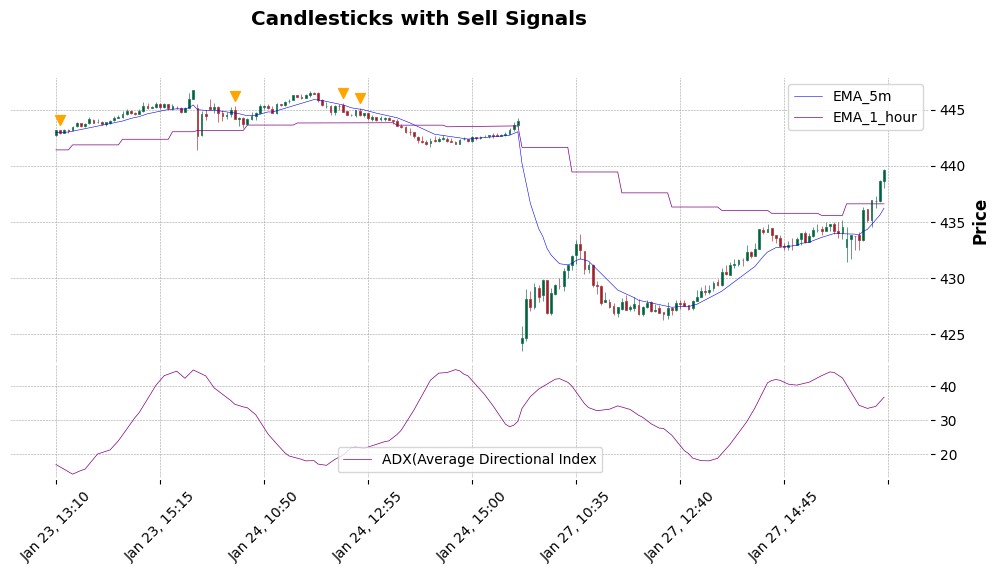

In [17]:
df_1 = df[200:400]
signal_prices_2 = pd.Series(index = df_1.index)
# signal_prices_1 = df_1['High'] * 1.0020
# signal_prices_1[df_1['signal'] != 1] = np.nan
signal_prices_2[df_1['signal_momentum_5m'] ==1] = df_1['High'] * 1.0020
print(signal_prices_2)


# signal_prices = df['High'][df['signal'] == 1] * 1.01  # 1% above High
ap = [mpf.make_addplot(
    signal_prices_2,
    type='scatter',
    markersize=50,
    marker='v',
    color='orange',
    panel=0
), mpf.make_addplot(df_1['EMA_5m'], type ='line', color='blue', width=0.4, label='EMA_5m'),mpf.make_addplot(df_1['EMA_1h'],type='line', color='purple', width=0.5, label='EMA_1_hour'),
      mpf.make_addplot(df_1['ADX'],panel=1, type='line', color='purple', width=0.5 ,label = 'ADX(Average Directional Index')]

mpf.plot(
    df_1,
    type='candle',
    style='charles',
    addplot=ap,
    title='Candlesticks with Sell Signals',
    ylabel='Price', figratio=(20, 9),   # sets the aspect ratio
         figscale=1.0
)

In [11]:
def backtest_strategy_1(data):
   
    trades = []
    entry_signals = data[data['signal_momentum_5m'] == 1].index
    
    for entry_time in entry_signals:
        
        entry_idx = data.index.get_loc(entry_time)
        prev_Range = df['High'].iloc[entry_idx-1] - df['Low'].iloc[entry_idx-1]
        if entry_idx == 0:
            continue  # Skip first index to have previous candle
         
        # Entry price (signal candle's high)
        entry_price = data.iloc[entry_idx]['Close']
        
        # Initial stop loss (previous candle's low)
        initial_stop =entry_price + (prev_Range * 0.8) #data.iloc[entry_idx]['High']
        risk = entry_price - initial_stop          #negative quantity 
        tp = entry_price + (risk * 3)
        
        # Trade tracking logic
        exit_price = None
        for j in range(entry_idx+1, len(data)):
            current = data.iloc[j]
            if current['High'] >= initial_stop:
                exit_price = initial_stop
                break
            if current['Low'] <= tp:
                exit_price = tp
                break
        if exit_price is None:
            exit_price = data.iloc[-1]['Close']
        
        pnl = entry_price - exit_price
        rrr = (exit_price - entry_price) / risk if risk != 0 else 0
        trades.append({'rrr': rrr})
    
    return pd.DataFrame(trades)

trade_history = backtest_strategy_1(df)
trade_history['rrr'].sum()

np.float64(41.0)

In [ ]:
#This Backtest is based upon the best parameter values given by Optuna (Machine Learning Module/Hyperparametrization)
# Best parameters: {'adx_window': 14, 'adx_threshold': 11, 'ema_5m_span': 12, 'ema_1h_span': 12,
#'stop_loss_multiplier': 0.8052855953299727, 'take_profit_multiplier': 2.94759768241191}